In [1]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import gc
import collections
import statsmodels.api as sm
import scipy
import xarray as xr

# Third-party dependencies
# NOTE: Local xeofs to be submitted as pull-request (addition of xeofs.model.reconstruct_randomized_X method)
from xeofs.xarray import EOF
from xarrayutils.utils import linear_trend

In [2]:
# Define local plotting parameters
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 25})
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica Neue')

In [3]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS

# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'

# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Folder for output figures
figures_folderpath = 'reports/figures/' 

interim_data_folder = 'data/interim/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
cise_file_path = 'cise_data/'
reconstructions_neofs_path = 'reconstructions_neofs/'
std_file_path = 'standardized_rec_data/'

## Data input (pre-processed)

In [ ]:
data = xr.open_dataset(inDirName + regriddedFluxSSH_filepath)
flux = data.timeMonthly_avg_landIceFreshwaterFlux
ssh = data.timeMonthly_avg_ssh

# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)
# Convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();
# Specify projection for data file
data.rio.write_crs("epsg:3031",inplace=True);
# Specify projection for data file flux array
flux.rio.write_crs("epsg:3031",inplace=True);

## Processed/Clean Data Input

In [4]:
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

In [5]:
flux_clean_tmean = flux_clean.mean('time')
flux_clean_tstd = flux_clean.std('time')

## Data Standardization

In [6]:
flux_clean_demeaned = flux_clean - flux_clean_tmean
flux_clean_standardized = flux_clean_demeaned/flux_clean_tstd

In [ ]:
flux_clean_ts = flux_clean.sum(['x','y'])
flux_clean_demeaned_ts = flux_clean_demeaned.sum(['x','y'])
flux_clean_standardized_ts = flux_clean_standardized.mean(['x','y'])

In [ ]:
# Figure: Anomalies / Internal Variability Component of Input Data: Temporal Variability
plt.figure(figsize=(45,5))
#plt.plot(flux_clean_standardized_ts[:], color = '#44546A', linewidth=2)
plt.plot(flux_clean_ts[:], color = 'r', linewidth=2)
#plt.plot(flux_clean_demeaned_ts[:], color = 'r', linewidth=2)
plt.title('Anomalies / Internal Variability Component')
plt.ylabel('Freshwater Flux (kg/m2/s)')
plt.xlabel('Time (months)')

## Spatial Decomposition: EOF

In [49]:
%%time
model = EOF(flux_clean)
model.solve()
eofs = model.eofs()
pcs = model.pcs()
nmodes = model.n_modes
varexpl = model.explained_variance_ratio()

CPU times: user 2min 29s, sys: 55.6 s, total: 3min 25s
Wall time: 54.6 s


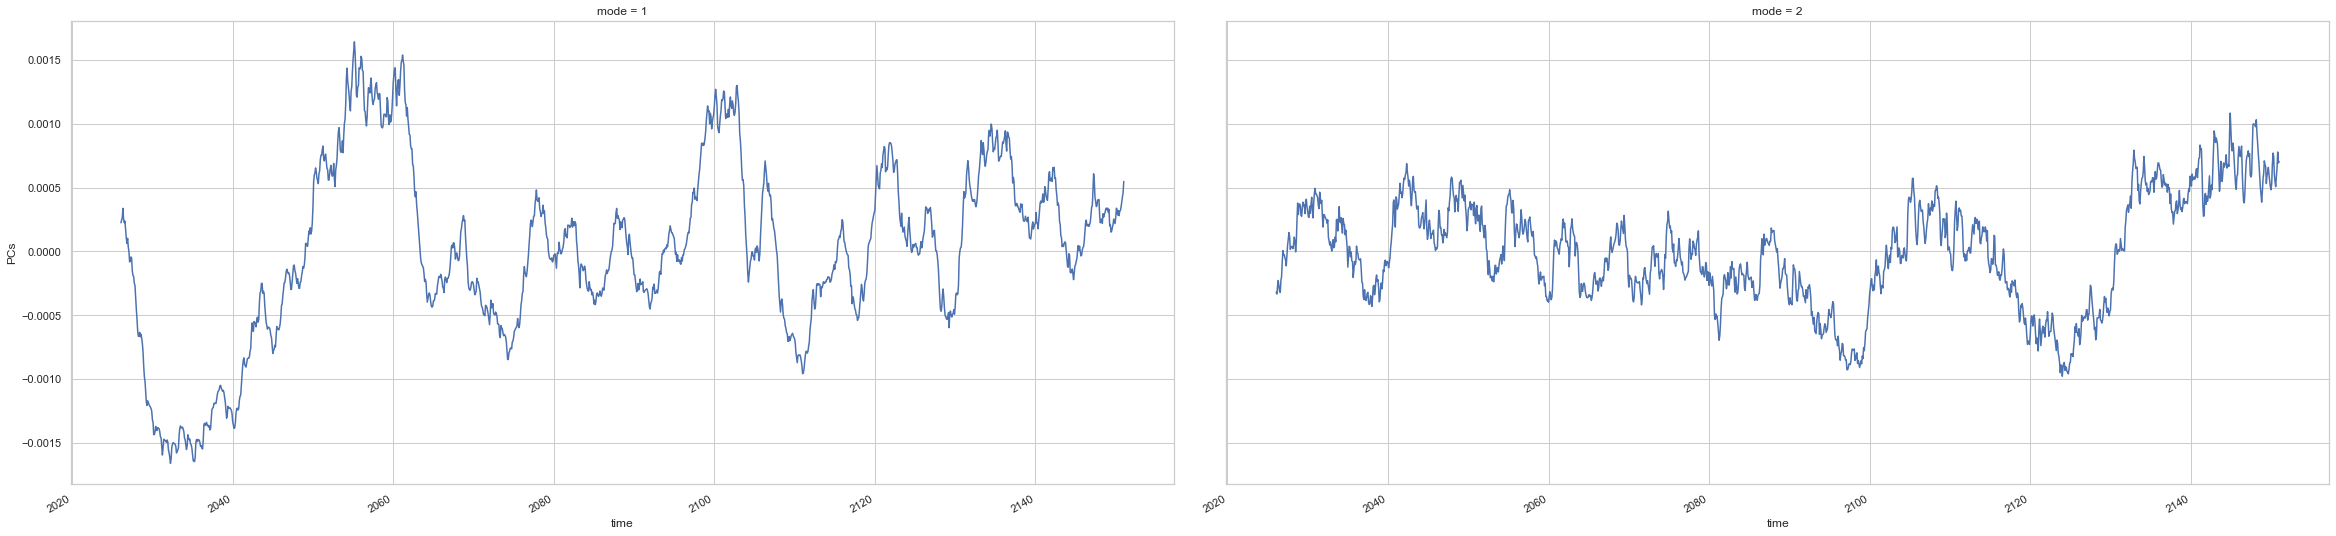

In [27]:
fg = pcs_sng[:,0:2].plot(aspect=2,size=8,col="mode",col_wrap=2)

### EOF Sample Robustness Checks

#### How robust are the structures to the sample used? 
If you divide the sample into randomly chosen halves and do the analysis on each half, do you consistently get the
same structures?

## Figures

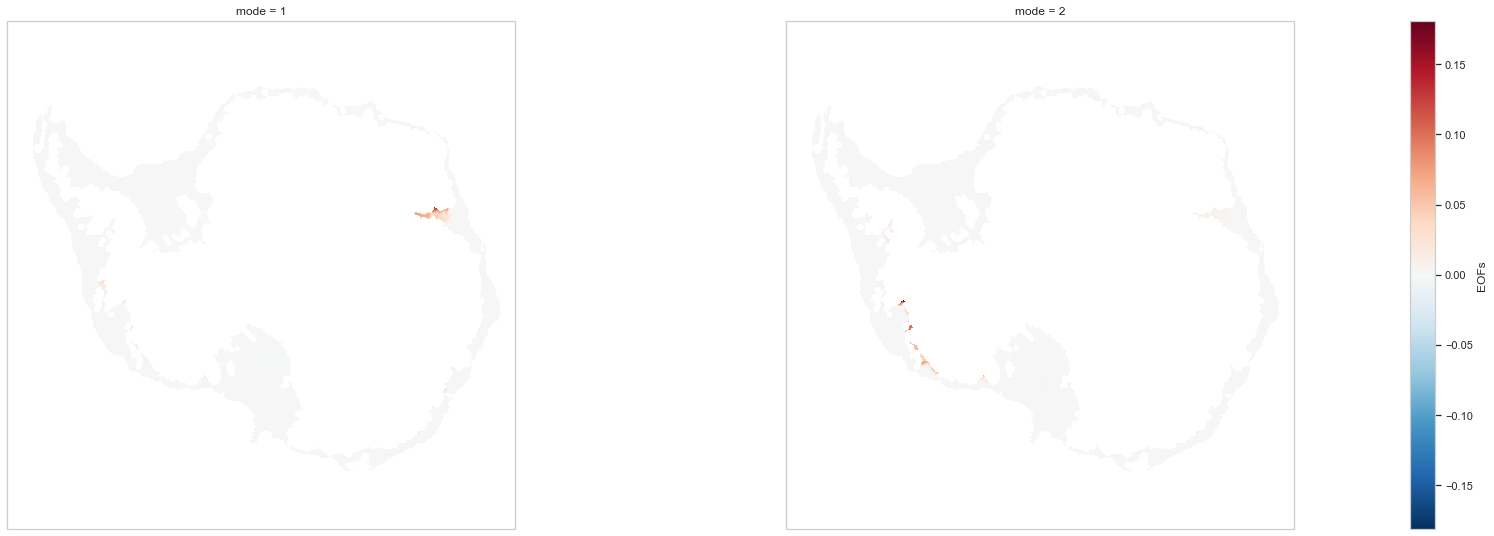

In [53]:
# Figure: Dominant EOF modes
fg = eofs[:,:,0:2].plot(aspect=2,
                        size=8,
                        col="mode", 
                        col_wrap=2,
                        subplot_kws=dict(projection=ccrs.SouthPolarStereo()))

# TODO: Redefine vmax, vmin 

#### Is the variance explained by the EOF more than you would expect if the data had no structure? 
What is the null hypothesis for the data field? \
Is it white noise? Is it red noise?
#### Are there any a priori reason for expecting these structures? 
Are the structures explainable in terms of some theory? \
Do the spatial and temporal structures of the modes behave consistently with theory and a priori expectation?
#### How robust are the structures to the choice of structure domain? 
If you change the domain of the analysis, do the structures change significantly? \
If the structure is defined in geographical space, and you change the size of the region, do the structures change
significantly? \
If the structures are defined in a parameter space, and you add or remove a parameter, do the results change in a sensible manner, or randomly?

In [ ]:
# Figure: Relative power of m EOFs
m = 250

plt.figure(figsize=(15,8))
plt.bar(range(m),varexpl[:m]*100, 
        color='r', 
        label='Clean: {}'.format(varexpl[:m].sum().values*100))
plt.ylabel('Relative Power (%)')
plt.xlabel('EOF Mode')
plt.title('Total Relative Power of first {} EOFs'.format(m))
plt.legend()

## Fourier Phase Randomization

In [ ]:
%%time
##############################
# FOURIER PHASE RANDOMIZATION 
##############################

# Define number of random Fourier realizations
n_realizations = 1
t_length = pcs.shape[0]

# xeofs_pcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,pcs.shape[0],pcs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(nmodes):
        fl = pcs[:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
        print('calculated ifft for realization {}, mode: {}'.format(i,m))

In [ ]:
# FIGURE (FOR TESTING)

fig, axs = plt.subplots(2,2,figsize=(30,16))
axs=axs.ravel()

for mode_m in range(0,4):
    for i in range(0,1):
        axs[mode_m].psd(new_fl[i,:,mode_m],color='b', linewidth=0.5)
    axs[mode_m].psd(new_fl[0,:,mode_m],color='b', linewidth=0.25,label='Randomized')
    axs[mode_m].psd(pcs[:,mode_m],color='k', linewidth=1.5,label='Original')
    axs[mode_m].set_title('PSD of PC for mode {}'.format(mode_m))
plt.legend()

## Helper Functions

In [ ]:
#modified to not return f - in calculation of RMSE, only Px required
def psd_calc_grid(data,y,x):
    f, Px = scipy.signal.welch(data[:,y,x])
    return Px

In [ ]:
def time_series(clipped_data):
    clipped_ts = clipped_data.sum(['y','x'])
    return clipped_ts

In [ ]:
# Reconstruct flux dataset using phase randomized PCs
# This section is to be called iteratively for ensemble runs with multiple realizations
# This method also takes 'modes' as a parameter: 
# which is used to reconstruct dataset with different number of selected modes

def generate_data(n_realization,mode,mode_skip):
    flux_reconstr = model.reconstruct_randomized_X(new_fl[n_realization],slice(1,mode,mode_skip))
    #flux_reconstr = flux_reconstr.dropna('time',how='all')
    #flux_reconstr = flux_reconstr.dropna('y',how='all')
    #flux_reconstr = flux_reconstr.dropna('x',how='all')
    #flux_reconstr = flux_reconstr.drop("month")
    return flux_reconstr

In [ ]:
def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping))
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    clipped_data = clipped_data.drop("month")
    return clipped_data

## Generator

In [ ]:
# Generate dataset realizations
# Note standardized input data to the initial PCA 
for i in range(n_realizations):
    flux_reconstr = generate_data(i, 1500, 1)
    flux_reconstr = (flux_reconstr*flux_clean_tstd)+flux_clean_tmean
    flux_reconstr.to_netcdf(inDirName+interim_data_folder+
                            cise_file_path+std_file_path+"flux_reconstr_std_{}.nc".format(i))
    del flux_reconstr
    gc.collect()
    print('reconstructed realization # {}'.format(i))

In [ ]:
# change file name for other realizations
flux_reconstr0 = xr.open_dataset(inDirName+interim_data_folder+
                                 cise_file_path+std_file_path+'flux_reconstr_std_0.nc')
flux_reconstr0 = flux_reconstr0.__xarray_dataarray_variable__

In [ ]:
basins = np.array((34,55,114,103,104,105))

In [ ]:
for basin in basins:
    orig = clip_data(flux_clean, basin)
    rec0 = clip_data(flux_reconstr0, basin)
    orig.to_netcdf(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_{}".format(basin))
    rec0.to_netcdf(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_{}".format(basin))
    del orig, rec0
    gc.collect()

In [ ]:
# Amery 34
orig_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_34")
rec0_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_34")

# Filchner 55
orig_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_55")
rec0_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_55")

# Thwaites 114
orig_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_114")
rec0_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_114")

# Ronne 103
orig_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_103")
rec0_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_103")

# Western Ross 104
orig_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_104")
rec0_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_104")

# Eastern Ross 105
orig_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_105")
rec0_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_105")

In [ ]:
# Amery 
orig_34_ts = time_series(orig_34)
rec0_34_ts = time_series(rec0_34)

# Filchner 
orig_55_ts = time_series(orig_55)
rec0_55_ts = time_series(rec0_55)

# Thwaites 
orig_114_ts = time_series(orig_114)
rec0_114_ts = time_series(rec0_114)

# Ronne 
orig_103_ts = time_series(orig_103)
rec0_103_ts = time_series(rec0_103)

# Western Ross 
orig_104_ts = time_series(orig_104)
rec0_104_ts = time_series(rec0_104)

# Eastern Ross 
orig_105_ts = time_series(orig_105)
rec0_105_ts = time_series(rec0_105)

In [ ]:
fig, axs = plt.subplots(6,1,figsize=(30,24))
axs=axs.ravel()

axs[0].plot(orig_34_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[0].plot(rec0_34_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[0].set_title('Catchment: Amery');

axs[1].plot(orig_55_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[1].plot(rec0_55_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[1].set_title('Catchment: Filchner');

axs[2].plot(orig_114_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[2].plot(rec0_114_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[2].set_title('Catchment: Thwaites');

axs[3].plot(orig_103_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[3].plot(rec0_103_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[3].set_title('Catchment: Ronne');

axs[4].plot(orig_104_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[4].plot(rec0_104_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[4].set_title('Catchment: Western Ross');

axs[5].plot(orig_105_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[5].plot(rec0_105_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[5].set_title('Catchment: Eastern Ross');
plt.legend()

plt.suptitle('Realizations Generated using 1500 EOF modes');

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(30,18))
axs=axs.ravel()

axs[0].psd(orig_34_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[0].psd(rec0_34_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[0].set_title('Catchment: Amery');

axs[1].psd(orig_55_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[1].psd(rec0_55_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[1].set_title('Catchment: Filchner');

axs[2].psd(orig_114_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[2].psd(rec0_114_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[2].set_title('Catchment: Thwaites');

axs[3].psd(orig_103_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[3].psd(rec0_103_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[3].set_title('Catchment: Ronne');

axs[4].psd(orig_104_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[4].psd(rec0_104_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[4].set_title('Catchment: Western Ross');

axs[5].psd(orig_105_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[5].psd(rec0_105_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[5].set_title('Catchment: Eastern Ross');
plt.legend()